In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Input 
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization, Concatenate, Reshape
from tensorflow.keras.applications import VGG16
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt 
import os 
import numpy as np
from PIL import Image
from random import shuffle
import random
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive/')
data_path = f'/content/gdrive/My Drive/Object Localization'

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
def getBB(file):
  
  #parse the annotations
  path = data_path + f'/annotations/xmls/{file}'
  tree = ET.parse(path)
  root = tree.getroot()
  
  ob = root.find('object')
  bndbox = ob.find('bndbox')
  xmin = bndbox.find('xmin').text
  xmax = bndbox.find('xmax').text

  ymin = bndbox.find('ymin').text
  ymax = bndbox.find('ymax').text

  return((int(xmin), int(ymin)), (int(xmax), int(ymax)))

def drawBB(file):
  #draw the bounding box
  img_path = data_path + f'/images/{file[:-4]}.jpg' 
  img = cv2.imread(img_path)
  
  (xmin, ymin), (xmax, ymax) = getBB(file)

  print(getBB(file))
  annotated = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0,255,0), 2)
  
  plt.figure(figsize=(9,9))
  plt.imshow(annotated[:,:,::-1])
  plt.axis('off')
  plt.show()

((1, 172), (271, 490))


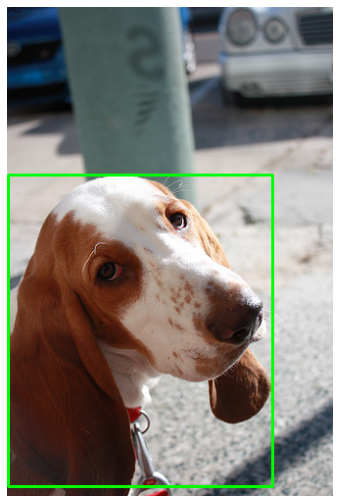

In [4]:
file = np.random.choice(os.listdir(data_path + f'/annotations/xmls'))
drawBB(file)

In [0]:
def image_generator(files, batch_size = 32, sz = (256, 256)):
  
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    
    for f in batch:
      img_path = data_path + f'/images/{f[:-4]}.jpg'
      img = Image.open(img_path)
      w,h = img.size
      
      img = img.resize(sz)
      (xmin, ymin), (xmax, ymax) = getBB(f)
      
      img = np.array(img).astype('float32')
      if len(img.shape) == 2:
        img = np.stack((img,)*3, axis=-1)

      else:
        img = img[:,:,0:3]
      
      box = np.array([xmin/w, ymin/h, xmax/w, ymax/h])

      batch_x.append(img/255)
      batch_y.append(box)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)
    batch_y = np.array(batch_y)

    yield (batch_x, batch_y)      
    

In [6]:
batch_size = 32
IMG_SIZE = 256

all_files = os.listdir(data_path + f'/annotations/xmls')
shuffle(all_files)

split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

print('Size of training ', len(train_files))
print('Size of testing  ', len(test_files))
train_generator = image_generator(train_files, batch_size = batch_size, sz = (IMG_SIZE, IMG_SIZE ))
test_generator  = image_generator(test_files, batch_size = batch_size, sz = (IMG_SIZE, IMG_SIZE ))

Size of training  3501
Size of testing   185


In [0]:
x, y = next(train_generator)

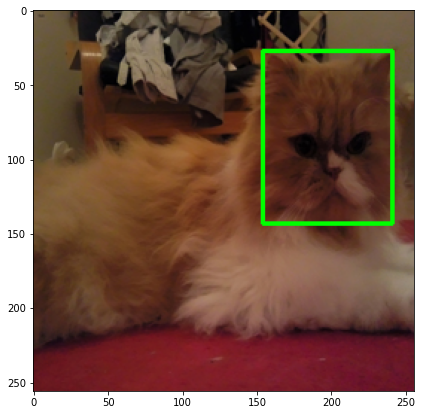

In [8]:
img = (x[0] * 255).astype('uint8')
box = y[0]
box = [int(IMG_SIZE *i) for i in box]

annotated = cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (0,255,0), 2)
plt.figure(figsize=(7,7))
plt.imshow(annotated)

**Keras ImageDataGenerator**

```
batch_size = 32
IMG_SIZE = 256

all_files = os.listdir(data_path + f'/annotations/xmls')
shuffle(all_files)

split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

print('Size of training ', len(train_files))
print('Size of testing  ', len(test_files))
```

```
def append_ext(file):
    return file[:-4] + ".jpg"

traindf = pd.DataFrame()
traindf['id'] = train_files
# traindf["label"] = traindf["id"].apply(getBB)
# traindf["id"] = traindf["id"].apply(append_ext)

testdf = pd.DataFrame()
testdf['id'] = test_files
# testdf["label"] = testdf["id"].apply(getBB)
# testdf["id"] = testdf["id"].apply(append_ext)
```

```

# Using ImageDataGenerator to read images from directories
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

data_dir = data_path + f'/images'
train_generator = train_datagen.flow_from_dataframe(dataframe=traindf,
                                                    directory=data_dir,
                                                    x_col="id",
                                                    y_col="label",
                                                    target_size=(150, 150), # Resizes all images to 150 × 150
                                                    batch_size=20,
                                                    class_mode='binary') # Class mode needs to be changed

test_generator = test_datagen.flow_from_dataframe(dataframe=testdf,
                                                  directory=data_dir,
                                                  x_col="id",
                                                  y_col="label",
                                                  target_size=(150, 150), # Resizes all images to 150 × 150
                                                  batch_size=20,
                                                  class_mode='binary')
```





# Evaluation Metric

https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

https://medium.com/@venuktan/vectorized-intersection-over-union-iou-in-numpy-and-tensor-flow-4fa16231b63d

https://venuktan.wordpress.com/2018/03/02/vectorized-intersection-over-union-iou-in-numpy-and-tensor-flow/

In [0]:
def iou(tb1, tb2):
  x11, y11, x12, y12 = tf.split(tb1, 4, axis=1)
  x21, y21, x22, y22 = tf.split(tb2, 4, axis=1)

  xA = tf.maximum(x11, tf.transpose(x21))
  yA = tf.maximum(y11, tf.transpose(y21))
  xB = tf.minimum(x12, tf.transpose(x22))
  yB = tf.minimum(y12, tf.transpose(y22))

  interArea = tf.maximum((xB - xA + 1), 0) * tf.maximum((yB - yA + 1), 0)

  boxAArea = (x12 - x11 + 1) * (y12 - y11 + 1)
  boxBArea = (x22 - x21 + 1) * (y22 - y21 + 1)

  iou = interArea / (boxAArea + tf.transpose(boxBArea) - interArea)

  return iou

# Create the Model

**Functional API**

https://machinelearningmastery.com/keras-functional-api-deep-learning/

https://keras.io/guides/functional_api/

**Callbacks**

https://keras.io/api/callbacks/

https://keras.io/api/callbacks/model_checkpoint/


**Keras Conv2D**

https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/

**Batch vs Epoch**

https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/

In [10]:
def create_model(trainable=False):
  model = VGG16(input_shape=(256, 256, 3), include_top=False, weights='imagenet')

  # to freeze layers
  for layer in model.layers:
    layer.trainable = trainable

  x = model.layers[-1].output
  x = Conv2D(4, kernel_size=(3,3), name="coords")(x)
  x = Flatten()(x)
  x = Dropout(0.5)(x)
  out = Dense(4, activation = 'sigmoid')(x)

  return tf.keras.models.Model(inputs=model.input, outputs=out)

model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [0]:
model.compile(optimizer = 'adam' , loss = 'mean_squared_error', metrics = [iou])

In [0]:
# Model weights are saved at the end of every epoch, if it's the best seen so far.
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_iou', mode='max', save_weights_only= True, verbose = 0)

# Stop training when a monitored metric has stopped improving.
stop = EarlyStopping(monitor="val_iou", patience=50, mode="max")

# Reduce learning rate when a metric has stopped improving.
reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")

# Training



In [0]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size

model.fit_generator(train_generator,
                    epochs = 30,
                    steps_per_epoch = train_steps,
                    validation_data = test_generator,
                    validation_steps = test_steps,
                    callbacks=[checkpoint, reduce_lr, stop])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
109/109 [==============================] - 2687s 25s/step - loss: 0.0389 - iou: 0.6158 - val_loss: 0.0160 - val_iou: 0.6776 - lr: 0.0010
Epoch 2/30
109/109 [==============================] - 2400s 22s/step - loss: 0.0215 - iou: 0.6444 - val_loss: 0.0177 - val_iou: 0.6715 - lr: 0.0010
Epoch 3/30
109/109 [==============================] - 2377s 22s/step - loss: 0.0173 - iou: 0.6483 - val_loss: 0.0124 - val_iou: 0.6792 - lr: 0.0010
Epoch 4/30
109/109 [==============================] - 2362s 22s/step - loss: 0.0136 - iou: 0.6581 - val_loss: 0.0097 - val_iou: 0.6903 - lr: 0.0010
Epoch 5/30
109/109 [==============================] - 2378s 22s/step - loss: 0.0125 - iou: 0.6595 - val_loss: 0.0105 - val_iou: 0.6644 - lr: 0.0010
Epoch 6/30
109/109 [==============================] - 2363s 22s/step - loss: 0.0103 - iou: 0.6648 - val_loss: 0.0092 - val_iou: 0.6895 - lr: 0.0010
Epoch 7/30
109/109 [================

# Prediction

In [0]:
#load the best model 
model.load_weights('best_model.h5')

In [0]:
x,y = next(test_generator)
img = x[0]
box = model.predict(np.expand_dims(img, 0))[0]
box = [int(IMG_SIZE*i) for i in box]
annotated = cv2.rectangle((img*255) , (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
box = [int(IMG_SIZE * i) for i in y[0]]
annotated = cv2.rectangle((annotated) , (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)

plt.axis('off')
plt.imshow((annotated ).astype('uint8'))